In [1]:
# Import modules.
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import scipy.stats
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
from matplotlib import cm

## Problem 3
### (c)
plot log likelihood value as 3D surface plot:\
x-axis: run over $x_0$\
y-axis: run over $\gamma$\
z-axis: log likelihood value at the corresponding $(x_0, \gamma)$

In [2]:
df = pd.read_csv('problem3.csv', header=None)
data = np.array(df)

In [3]:
def neg_loglikelihood(theta, data):
    num_points = data.shape[0]
    x0, gamma = theta
    loglikelihood = -num_points * np.log(np.pi) - num_points * gamma
    loglikelihood = loglikelihood - sum (np.log(1 + ((data-x0)/np.exp(gamma))**2))
    return - loglikelihood

(40, 40) (40, 40) (40, 40)


Text(0.5, 0, 'Negative Log Likelihood')

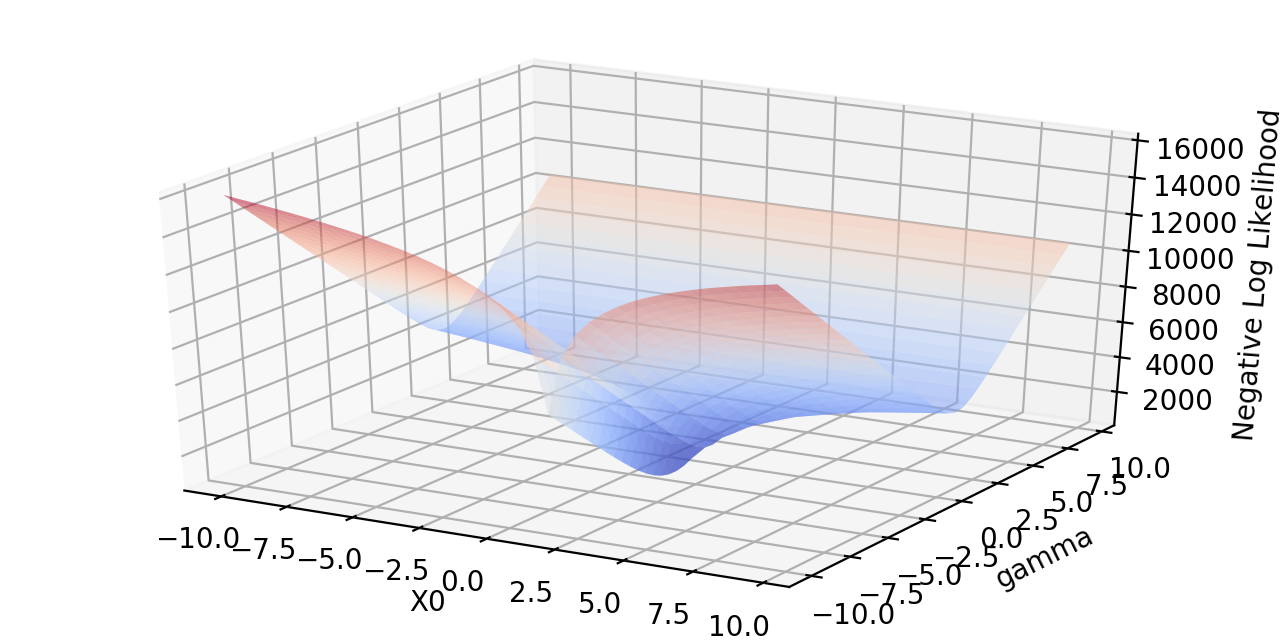

In [4]:
# Plot
fig = plt.figure(figsize=(8,4), dpi=200)
ax = fig.add_subplot(111, projection='3d')
x = np.arange(-10, 10, 0.5)
y = np.arange(-10, 10, 0.5)
X, Y = np.meshgrid(x, y)
#print(np.ravel(X).shape)
#print(x.shape)

def fun(x, y, data):
    return np.array([
    neg_loglikelihood((x_value, y_value), data) for x_value, y_value in zip(x,y) ])
zs = np.array(fun(np.ravel(X), np.ravel(Y), data))
Z = zs.reshape(X.shape)
print(Z.shape, Y.shape, X.shape)

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.5)

ax.set_xlabel('X0')
ax.set_ylabel('gamma')
ax.set_zlabel('Negative Log Likelihood')

### (d)
obtain an estimator $\theta = (x_0, \gamma)$

In [5]:
def neg_loglikelihood_grad(theta, data):
    num_points = data.shape[0]
    x0, gamma = theta
    grad = np.zeros((2,))
    grad[0] = sum(2*(data-x0)/np.exp(2*gamma)/(1+((data-x0)/np.exp(gamma))**2))
    grad[1] = - num_points + sum((2*((data-x0)/np.exp(2*gamma)))/(1+((data-x0)/np.exp(gamma))**2))
    return - grad

In [6]:
theta = np.array([0.0,1.0])
x0_array=[]
gamma_array=[]
def neg_loglikelihood_update(theta, data):
    global x0_array
    global gamma_array
    num_points = data.shape[0]
    x0, gamma = theta
    loglikelihood = -num_points * np.log(np.pi) - num_points * gamma
    loglikelihood = loglikelihood - sum (np.log(1 + ((data-x0)/np.exp(gamma))**2))
    x0_array.append(x0)
    gamma_array.append(gamma)
    return - loglikelihood

res = minimize(neg_loglikelihood_update, theta, method='BFGS', 
               jac = neg_loglikelihood_grad, args=(data,))
print(res)

      fun: 2066.661738096842
 hess_inv: array([[ 3.36690228, -3.36759245],
       [-3.36759245,  3.36927259]])
      jac: array([-847.22585653,  152.77414347])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 1
     njev: 24
   status: 2
  success: False
        x: array([0.38377301, 0.06575256])


In [7]:
pd.DataFrame(data ={'X0':list(x0_array), 'gamma': list(gamma_array)})

,X0,gamma
0,0.000000,1.000000
1,0.383773,0.065753
2,1.235930,-0.786618
3,4.644559,-4.196098
4,1.440424,-0.991162
5,1.618759,-1.169542
6,3.131659,-2.682820
7,1.689599,-1.240400
8,1.624146,-1.174931
9,1.619262,-1.170045


## Problem 4
### (b)

In [8]:
def GDRidge(x, y, T, eta, lam):
    n = y.shape[0]
    n_feature = x.shape[1]
    b = 0
    w = np.zeros(n_feature)
    w_array = []
    ridge_array = []
    for i in range(T):
        w_array.append(np.sqrt(np.dot(w, w)))
        ridge_array.append(L(x, y, n, w, b, lam))
        b_grad = 0
        w_grad = 0
        for j in range(n):
            b_grad += 2*(y[j]-b-np.dot(w, x[j]))
            w_grad += 2*(y[j]-b-np.dot(w, x[j]))*x[j]
        b_new = b + (eta/n)*b_grad
        w_new = w + eta*(w_grad/n - 2*lam*w)
        b = b_new
        w = w_new
    return b, w, ridge_array, w_array

def L(x, y, n, w, b, lam):
    n = y.shape[0]
    acc = 0
    for k in range(n):
        acc += (y[k]-b-np.dot(w,x[k]))**2
    Lr = acc/n + lam*np.sum(w**2)
    return Lr

### (c)

In [9]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
boston = load_boston()
x = StandardScaler().fit_transform(boston.data)
y = MinMaxScaler().fit_transform(boston.target.reshape(-1,1))
df = pd.DataFrame(x, columns = boston.feature_names)
y = y.reshape(-1)
df['target'] = y

In [13]:
T = 100
eta = 0.01
lam = 0.
b, w, ridge_array, w_array = GDRidge(x, y, T, eta, lam)

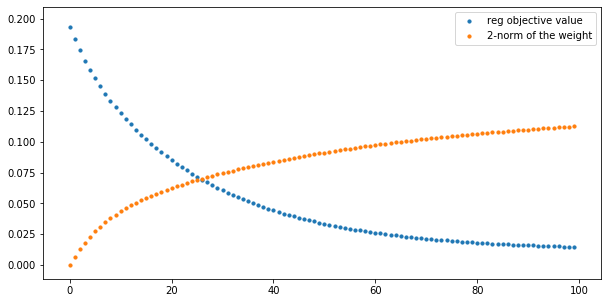

In [14]:
plt.figure(figsize=(10,5))
plt.scatter(range(100), ridge_array, s = 10, label = "reg objective value")
plt.scatter(range(100), w_array, s = 10, label = "2-norm of the weight")
plt.legend(loc='best')

### (d)

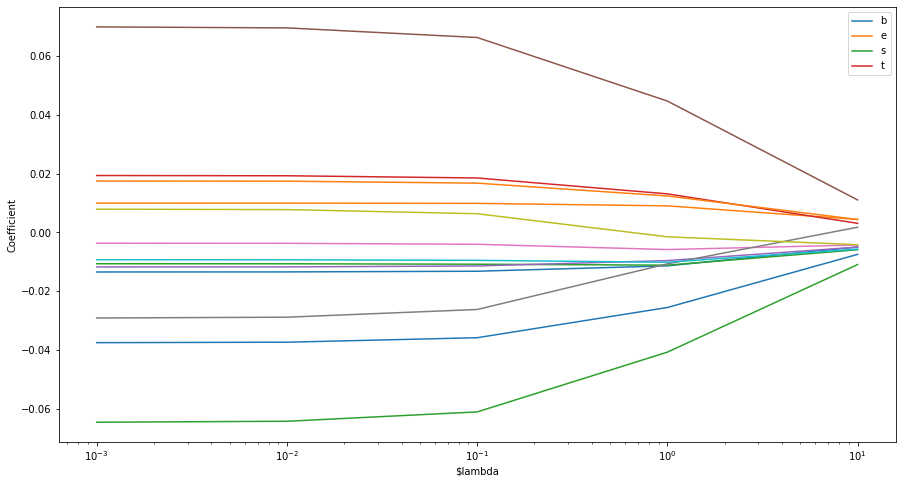

In [17]:
l = [10, 1, 0.1, 0.01, 0.001]
n_feature = x.shape[1]
w_lst = []
for i in l:
    b, w, ridge_array, w_array = GDRidge(x, y, 100, 0.01, lam=i)
    w_lst.append(w)
w_lst = np.transpose(w_lst)

plt.figure(figsize=(15,8))
for k in range(n_feature):
    plt.plot(l, w_lst[k], label = 'Feature {}'.format(df.columns[k]))

plt.xscale('log')
plt.xlabel('$lambda')
plt.ylabel('Coefficient')
plt.legend('best')



Coefficients converfes to 0 as the regularization parameter $\lambda$ getting larger.